## Import data
Load buffers, road network, and habitat data from files.

The habitats data is in CSV format, each entry represents a habitat within a buffer, with the following properties
- `buffer_id`: ID of the buffer to which the habitat belongs
- `TypoCH`: Swiss TypoCH habitat type code
- `habitat_area`: Area of the habitat within the buffer in square meters
- `percentage`: Percentage of the buffer area that is covered by this habitat type

In [1]:
import geopandas as gpd
import pandas as pd
from src.utils import get_habitat_name, most_common_habitat, create_fragmentation_index, get_dominant_habitats, create_pie_chart, create_habitat_palette

buffers = gpd.read_file("../data/buffers/vaud_railway_buffers_250_500_250.geojson")
# buffers_lausanne = gpd.read_file("../data/buffers/lausanne_railway_buffers_150_300_150.geojson")
rail_vaud = gpd.read_file("../data/railway_networks/Vaud_rail_100_150_200.gpkg")
rail_lausanne = gpd.read_file("../data/railway_networks/Lausanne_rail_100_150.gpkg")
rail_data = pd.read_csv("../data/railway_networks/rail_data_in_vaud_railway_buffers.csv")
habitats = pd.read_csv("../data/habitats/habitats_in_vaud_railway_buffers.csv")
# habitats_lausanne = pd.read_csv("../data/habitats/habitats_in_lausanne_railway_buffers.csv")
typoch_names = pd.read_csv('../data/habitats/typoCH_names.csv')

### Lausanne Area
To focus on the Lausanne area, uncomment the following lines to crop the buffers to the Lausanne area.

In [3]:
# import osmnx as ox
# from shapely.geometry import box
# # Crop the buffers to for the greater Lausanne area
# la_greater = ox.geocode_to_gdf("Lausanne, Switzerland")
# buffers = buffers.to_crs(la_greater.crs)
# minx, miny, maxx, maxy = 6.52, 46.45, 6.72, 46.62
# lausanne_bbox = box(minx, miny, maxx, maxy)
# bbox_gdf = gpd.GeoDataFrame({'geometry': [lausanne_bbox]}, crs="EPSG:4326")
# buffers_clipped = gpd.clip(buffers, bbox_gdf)
# buffers_clipped.to_file("../data/buffers/A9_buffers_lausanne.geojson", driver="GeoJSON")
# buffers = buffers_clipped

## Most common habitat types along road

In [4]:
most_common_habitat(habitats, typoch_names)

--- VAUD ---

----- 10 Most common habitats by total area -----

8.2: Field crops, 14,395,071 m²
9: Built habitats, 12,315,819 m²
9.2: Building, 7,814,666 m²
9.3.2: Surfaced roads, 6,724,430 m²
8.1.6: Vineyards, 4,876,458 m²
4: Grasslands, 4,501,317 m²
4.5.1: Medio-European lowland hay meadows, 4,457,047 m²
6.3.3: Oak-Hornbeam forests, 4,215,087 m²
1.1: Standing fresh water, 4,126,764 m²
5.3: Scrubs, brushes and clearings, 3,711,549 m²


### Dominant Habitat Type in Each Buffer
For each buffer, get the TypoCH with the largest `habitat_area`

In [5]:
habitats = habitats.dropna()
dominant_habitat = get_dominant_habitats(habitats)

# Merge the dominant habitat type back into the buffers GeoDataFrame
buffers = buffers.merge(dominant_habitat, on='buffer_id', how='left')
print(buffers.columns)

Index(['buffer_id', 'geometry', 'dominant_typoch'], dtype='object')


In [6]:
# Check for unmatched buffer_ids
unmatched_ids = buffers[buffers['dominant_typoch'].isna()]['buffer_id']
print(f"Unmatched buffer_ids: {unmatched_ids}")

Unmatched buffer_ids: 123    124
178    179
Name: buffer_id, dtype: int32


In [7]:
# Drop rows where dominant_typoch is NaN
buffers = buffers.dropna(subset=['dominant_typoch'])

There are 22 habitat types that are dominant in the buffers along the rail lines 100, 150 and 200 in Vaud.

We also create a mapping of the dominant habitat type category to the name of the habitat type for easier interpretation.

In [8]:
# Add name of dominant habitat type to buffers
buffers['dominant_habitat_name'] = buffers['dominant_typoch'].apply(lambda x: get_habitat_name(typoch_names, x))

## Habitat Fragmentation within buffers
We determine a fragmentation index for each buffer, which is the number of unique habitat types present in that buffer. This gives an indication of habitat diversity and fragmentation.

In [9]:
fragmentation_index = create_fragmentation_index(habitats)

# Merge the fragmentation index back into the buffers GeoDataFrame
buffers = buffers.merge(fragmentation_index, on='buffer_id', how='left')

In [10]:
print(f"maximum fragmentation in buffers: {max(fragmentation_index['fragmentation_index'])}")
print(f"minimum fragmentation in buffers: {min(fragmentation_index['fragmentation_index'])}")

maximum fragmentation in buffers: 32
minimum fragmentation in buffers: 6


## Visualization of buffers with habitat data


In [11]:
print(rail_data.columns)
print(rail_data['avg_speed'].unique())

Index(['buffer_id', 'avg_speed', 'max_speed', 'is_tunnel'], dtype='object')
[102.22222222 135.83333333 140.          85.         125.
 130.          80.         151.          95.         160.
  90.         105.         127.14285714 123.54166667 143.33333333
 136.         135.         110.         100.         120.
 153.33333333 127.5        131.         122.5        133.33333333
  45.90909091 112.5        150.         118.57142857  54.28571429
  49.10714286 114.28571429 111.25        40.         108.
 118.         123.57142857  97.5         89.09090909 104.54545455
 132.5        123.33333333  82.5        138.         113.33333333
  56.15384615 115.         118.75        76.52173913 128.75
 117.5         98.         136.31578947 145.         158.33333333
 128.46153846  93.33333333  87.5        146.66666667 122.08333333
 117.08333333 142.85714286 130.45454545 152.5        106.66666667
 117.27272727  49.375      131.66666667  65.         137.
  59.86111111  50.         124.44444444 124.54

In [12]:
# For the moment we keep only average speed
# Merge the selected columns from rail_data into buffers
buffers = buffers.merge(rail_data[['buffer_id', 'avg_speed']], on='buffer_id', how='left')

### Color Palette for Habitat Types

In [13]:
dom = buffers['dominant_typoch'].unique()

habitat_palette = create_habitat_palette(dom)

In [14]:
from src.utils import hex_to_rgba

buffers['color'] = buffers['dominant_typoch'].map(lambda t: hex_to_rgba(habitat_palette.get(t, '#CCCCCC'), alpha=100))

### Visualization

In [15]:
from src.buffers.data_in_buffers_visualization import visualize_buffers_habitat_data, visualize_buffers_data

buffers = buffers.to_crs(epsg=4326)
visualize_buffers_habitat_data(buffers, f"outputs/lausanne/rail_habitats_lausanne.html")
visualize_buffers_data(buffers,"fragmentation_index", "outputs/lausanne/rail_buffers_fragmentation_lausanne.html" )

### Pie Chart of Dominant Habitat Types

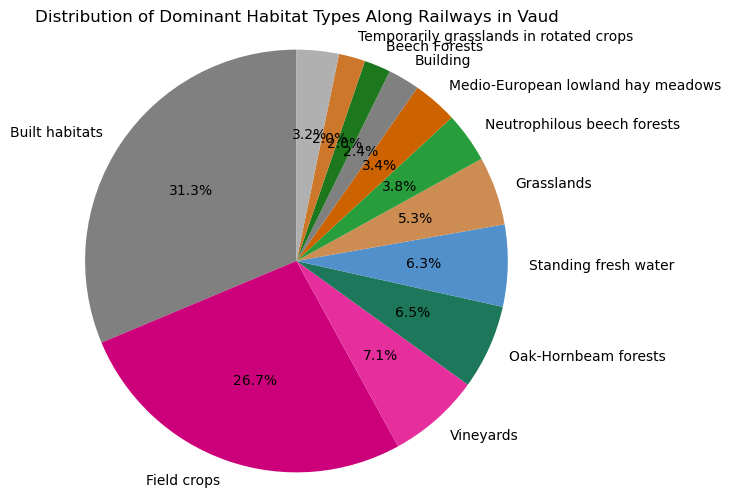

In [16]:
create_pie_chart(buffers['dominant_typoch'], habitat_palette, typoch_names, f"Distribution of Dominant Habitat Types Along Railways in Vaud")

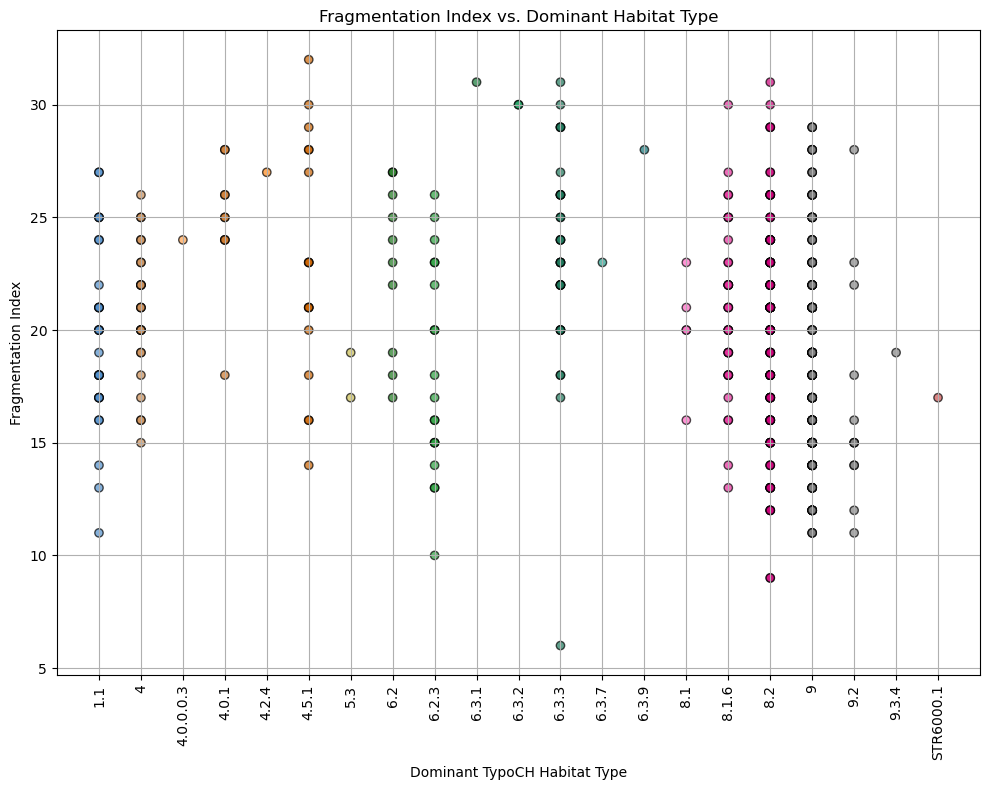

In [17]:
from src.utils import plot_fragmentation_dominant_type

plt = plot_fragmentation_dominant_type(buffers, habitat_palette)
plt.show()